In [1]:
# visulize the convergance of the numerical method

import sys
import petsc4py

petsc4py.init(sys.argv)

%pylab inline
pylab.rcParams['figure.figsize'] = (18.5, 10.5)

import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{mathtools, bm}"]

import numpy as np
import pandas as pd
from src import stokes_flow as sf
from src.StokesFlowMethod import *
from petsc4py import PETSc
import os
import re
import glob
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML
from scanf import scanf
from io import StringIO
from codeStore import support_fun as spf

PWD = os.getcwd()
fontsize = 40
np.set_printoptions(linewidth=110, precision=5)




Populating the interactive namespace from numpy and matplotlib


In [2]:
# for the paper m2, test the relative error between numerical and analytical values of uz
mat_contents = loadmat('convergence_z.mat')
b = mat_contents['b'][0][0]
# b = 0.8
z1 = mat_contents['z1'][0]
IDX = z1 > 0.013
convergence_z1 = z1[IDX]
R1 = mat_contents['R1'][0][IDX]
phi1 = mat_contents['phi1'][0][IDX]
ana_uz = mat_contents['u_struct'][0][-1][3][0][IDX]
nodes = np.vstack((R1 * np.cos(phi1), R1 * np.sin(phi1), convergence_z1)).T

# velocity (stokeslets) in infinite space
m = light_stokeslets_matrix_3d(nodes, np.array((b, 0, 0)))
uz_inf = np.dot(m, (0, 0, 1))[2::3]

fileHeadle = 'R09l20'
problem_kwargs = {
    'name':                        'force_pipe',
    'matrix_method':               'pf_stokesletsInPipe',
    'dp':                          -1,
    'ep':                          -1,
    'lp':                          -1,
    'rp':                          1,
    'b0':                          -1,
    'b1':                          -1,
    'nb':                          -1,
    'th':                          -1,
    'stokesletsInPipe_pipeFactor': -1,
    'solve_method':                'gmres',
    'precondition_method':         'none',
    'fileHeadle':                  fileHeadle,
    'check_acc':                   1,
    'plot_geo':                    0,
    'MPISIZE':                     0,
    'ffweightx':                   1,
    'ffweighty':                   1,
    'ffweightz':                   1,
    'ffweightT':                   1,
    'zoom_factor':                 1,
}
# velocity (stokeslets) in pipe 
problem = sf.StokesletsInPipeforcefreeProblem(**problem_kwargs)
problem.set_prepare(fileHeadle)
_, _, num_ans3 = problem.debug_solve_stokeslets_b(b=b, node=nodes)
num_uz = num_ans3.getArray().reshape((-1, 3))[:, 2]

# print('analytical, numerical, abs_err, relative_err')
# print(np.vstack((z1, ana_uz, num_uz, num_uz - ana_uz, (num_uz - ana_uz) / ana_uz)).T)

In [3]:
# check convergence1

# get data 1
dir_name1 = 'test_L_ds'
dir_name2 = 'case_use'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case?_L*_ds*_check_b*_u.mat' % t_dir)

L = []             # pipe length
ds = []            # delta length
b_list = []        # location of x_f
threshold = []     # cut of threshold
errx = []          # error of velocity
erry = []          # error of velocity
errz = []          # error of velocity
errx1 = []          # error of velocity
erry1 = []          # error of velocity
errz1 = []          # error of velocity
nnode = []         # amount of nodes

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    _, Li, dsi, bi = scanf('case%d_L%f_ds%f_check_b%f_u.mat', os.path.basename(mati))
    cthi = kwargs['th'][0]
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    t_nodes = mat_contents['nodes']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni
    errxi1 = np.sqrt(np.sum((u11_ana - u11_num) ** 2) / np.sum(u11_ana ** 2)) / ni
    erryi1 = np.sqrt(np.sum((u21_ana - u21_num) ** 2) / np.sum(u21_ana ** 2)) / ni
    errzi1 = np.sqrt(np.sum((u31_ana - u31_num) ** 2) / np.sum(u31_ana ** 2)) / ni
    
    L.append(Li)
    ds.append(dsi)
    b_list.append(bi)
    threshold.append(cthi)
    errx.append(errxi)
    erry.append(erryi)
    errz.append(errzi)
    errx1.append(errxi1)
    erry1.append(erryi1)
    errz1.append(errzi1)
    
data_err = pd.DataFrame({'L': np.hstack(L), 
                         'ds': np.hstack(ds), 
                         'b': np.hstack(b_list), 
                         'cth': np.hstack(threshold),
                         'errx': np.hstack(errx), 
                         'erry': np.hstack(erry), 
                         'errz': np.hstack(errz), 
                         'errx1': np.hstack(errx1), 
                         'erry1': np.hstack(erry1), 
                         'errz1': np.hstack(errz1), })\
               .pivot_table(index=['L', 'ds'], columns=['b'])
errx = data_err.errx
erry = data_err.erry
errz = data_err.errz
errx1 = data_err.errx1
erry1 = data_err.erry1
errz1 = data_err.errz1

# get data 2
txt_names = glob.glob('%s/*.txt' % t_dir)
L = []             # pipe length
ds = []            # delta length
nnode = []         # amount of nodes
threshold = []     # cut of threshold

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'pipe length:'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    L.append(temp1)
    
    text_headle = 'delta length, epsilon and factor of pipe are'
    temp2 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    ds.append(temp2)
    
    text_headle = 'Stokeslets in pipe prepare, contain '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'threshold of series is '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    threshold.append(temp1)

data_detail = pd.DataFrame({'L': np.hstack(L), 
                    'ds': np.hstack(ds), 
                    'nnode': np.hstack(nnode), 
                    'cth': np.hstack(threshold), })\
        .pivot_table(index=['L', 'ds'])
nnode = data_detail.nnode


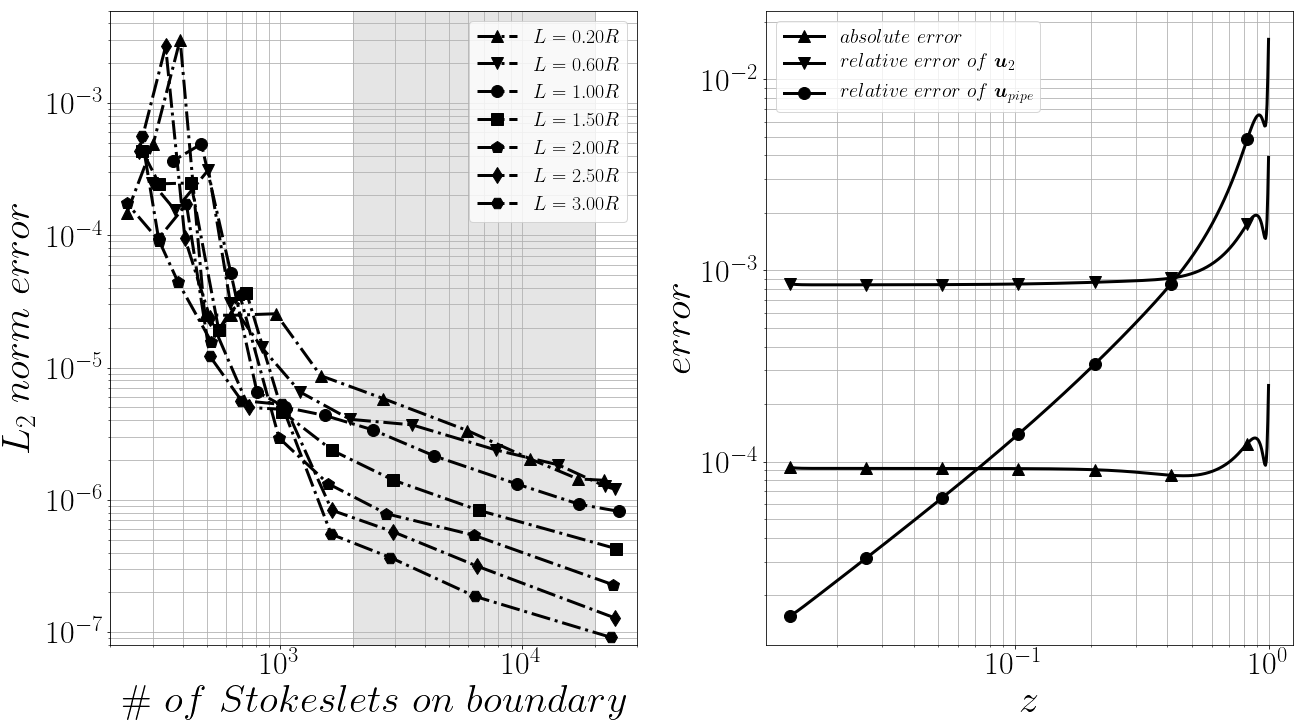

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 1)
# ax3 = ax2.twinx()
rel_err1 = np.abs((num_uz - ana_uz) / ana_uz)
rel_err2 = np.abs((num_uz - ana_uz) / (ana_uz - uz_inf))
rel_err3 = np.abs(num_uz - ana_uz)
# rel_err = np.abs((num_uz - ana_uz) / ana_uz)
# rel_err2 = np.abs((num_uz - ana_uz))
# rel_err2 = np.abs(ana_uz - uz_inf)

ax1.loglog(convergence_z1, rel_err3, '^-', linewidth=3, label='$absolute\ error$', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(convergence_z1, rel_err2, 'v-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{2}', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(convergence_z1, rel_err1, 'o-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{pipe}$', color='k', ms=fontsize*0.3, markevery=100)
ax1.legend(fontsize=fontsize*0.5, loc=2)
ax1.set_xlabel('$z$', size=fontsize)
ax1.set_ylabel('$error$', size=fontsize)
# ax1.set_xlim(0.01, 1.2)
# ax1.set_ylim(1e-5, 3e-2)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()

# # nnode-err
# bi = errx.columns[[5]].values
# t1 = errx[bi]
# for Li in t1.index.levels[0][1:]:
#     ty = t1.loc[Li].values.T[0]
#     tx = data_detail.loc[Li].nnode.values
#     ax2.loglog(tx, ty, '*-.', label='L=%.2f' % Li, linewidth=3)
# #     print(np.isfinite(tx) & np.isfinite(ty))
# #     print()
#     spf.fit_power_law(ax2, tx, ty, 2000, 10**4, linestyle='-', linewidth=5)
# # ax2.set_title('b=%f' % bi)
# ax2.legend()
# ax2.set_xlabel('$dof$', size=fontsize)
# ax2.set_ylabel('$err$', size=fontsize)
# # ax2.set_xlim(0.02, 0.3)
# ax2.set_ylim(10**-2, 10**2)
# xticks = (100, 1000, 10000, )
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
# # ax2.loglog((0.03, 0.1), (0.003, 10**((np.log10(0.1 / 0.03))*1.5 + np.log10(0.003))), 'b-', linewidth=5)
# plt.sca(ax2)
# plt.xticks(fontsize=fontsize*0.8)
# plt.yticks(fontsize=fontsize*0.8)
# plt.tight_layout()

# 1/ds-err
bi = errx.columns[[5]].values
t0 = errx[bi]
t1 = errx1[bi]
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'p-.', 'd-.', 'H-.']
for Li, lsi in zip(t0.index.levels[0], linestyle_list):
    ty = t0.loc[Li]
#     tx = 1 / ty.index
    tx = data_detail.loc[Li].nnode.values
    ty = t0.loc[Li].values.T[0]
    ty1 = t1.loc[Li].values.T[0]
    ax2.loglog(tx, ty, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     ax3.loglog(tx, ty1, '*-.', label='L=%.2f' % Li, linewidth=3)
#     spf.fit_power_law(ax2, tx, ty, 2000, 20000, linestyle='-', linewidth=5)
ax2.legend(fontsize=fontsize*0.5, loc=0)
ax2.set_xlabel('$\#\ of\ Stokeslets\ on\ boundary$', size=fontsize)
ax2.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax2.set_xlim(2e2, 3e4)
# # ax2.set_ylim(1e-2, 1e2)
# # ax2.loglog((15, 40), (1e-5, 10**((np.log10(15 / 40))*1.3 + np.log10(1e-5))), 'k-', linewidth=5)
# # ax2.loglog((13, 35), (2e-6, 10**((np.log10(13 / 35))*1.3 + np.log10(2e-6))), 'k-', linewidth=5)
# xticks = np.array([2e2, 1e3, 1e4, 3e4])
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
tylim = (8e-8, 0.005)
ax2.fill_between(np.array((2000, 20000)), *tylim, color='k', alpha=0.1)
ax2.set_ylim(tylim)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


y = -133.256717 + 19355.557676 * x in range (0.025831699371337891, 1.3376669883728027)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


log(y) = 0.970773 + 0.518534 * log(x) in range (122.70752500000003, 2985.5325959999996)
ln(y) = 2.235287 + 0.518534 * ln(x) in range (122.70752500000003, 2985.5325959999996)


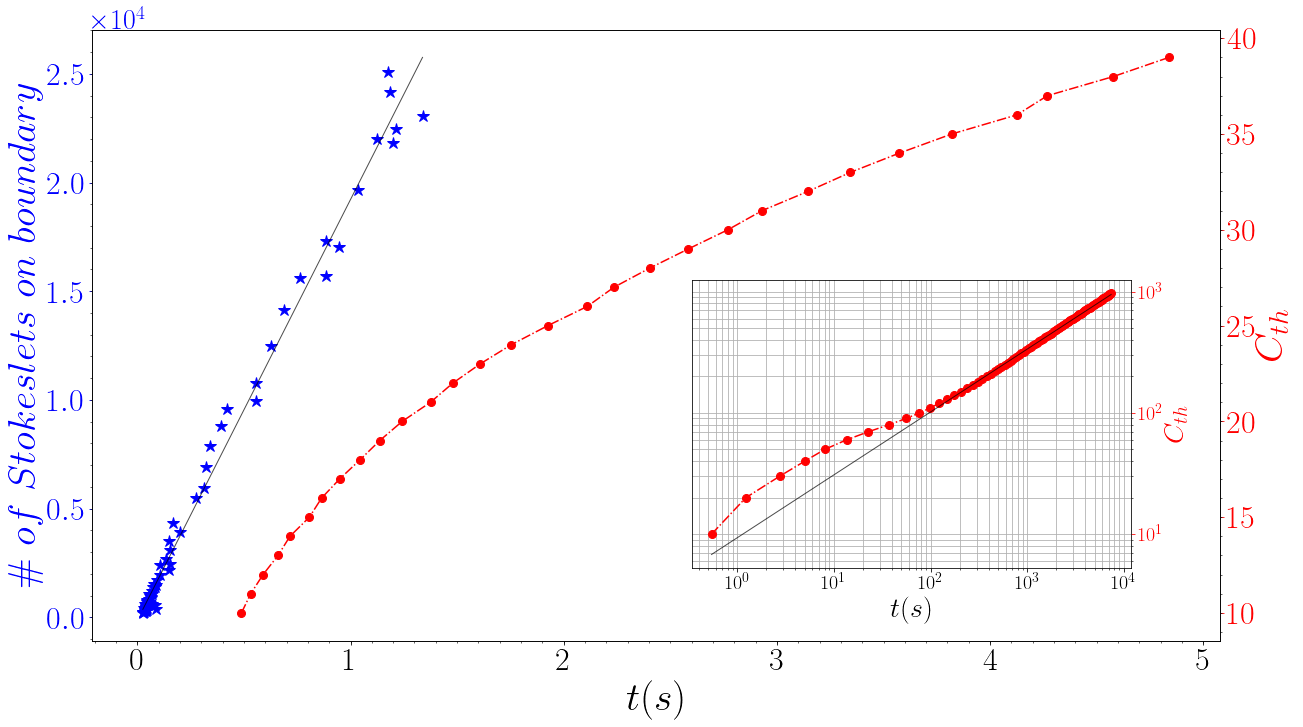

In [5]:
# speed of numerical and analytical methods
mat_contents = loadmat('num_ana_speed.mat')
dt_all = mat_contents['dt_all'].T[0]
dt_ana = mat_contents['dt_ana'].T[0]
dt_num = mat_contents['dt_num'].T[0]
cth_all = mat_contents['cth_all'].T[0]
cth = mat_contents['cth'].T[0]
nnode = mat_contents['nnode'].T[0]
idx = dt_ana < 5
dt_ana = dt_ana[idx]
cth = cth[idx]

fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax3 = plt.axes([.53, .23, .33, .38])

ax1.plot(dt_num, nnode, 'b*', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.tick_params('y', colors='b')
spf.fit_line(ax1, dt_num, nnode, 0, 2, ifprint=1, linestyle='-', linewidth=1)
ax1.set_xlabel('$t(s)$', size=fontsize)
ax1.set_ylabel('$\#\ of\ Stokeslets\ on\ boundary$', size=fontsize, color='b')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(1000))
# ax1.tick_params(axis='y', length=10, width=5)               
ax2.plot(dt_ana, cth, 'r.-.', ms=fontsize*0.4)
ax2.tick_params('y', colors='r')
ax2.set_ylabel('$C_{th}$', size=fontsize, color='r')
ax2.yaxis.set_minor_locator(MultipleLocator(1))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
# plt.grid(True, which='both')
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
# plt.grid(True, which='both')
plt.tight_layout()

ax3.loglog(dt_all, cth_all, 'r.-.', ms=fontsize*0.4)
ax3.tick_params('y', colors='r')
spf.fit_power_law(ax3, dt_all, cth_all, 100, 3000, linestyle='-', linewidth=1, extendline=True)
ax3.set_xlabel('$t(s)$', size=fontsize*0.7)
ax3.set_ylabel('$C_{th}$', size=fontsize*0.7, color='r')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
# ax3.yaxis.set_ticks((10, 1000))
plt.sca(ax3)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
plt.grid(True, which='both')
plt.tight_layout()


y = 0.270817 + 1.328638 * x in range (1, 1000)
y = 2.951245 + 1.328837 * x in range (1, 1000)
log(y) = 1.033436 + -0.592711 * x in range (10.0, 24.995152288027565)
ln(y) = 2.379574 + -1.364768 * x in range (10.0, 24.995152288027565)
log(y) = -1.724007 + 1.871816 * log(x) in range (300.00006799287132, 970.00019589976705)
ln(y) = -3.969674 + 1.871816 * ln(x) in range (300.00006799287132, 970.00019589976705)


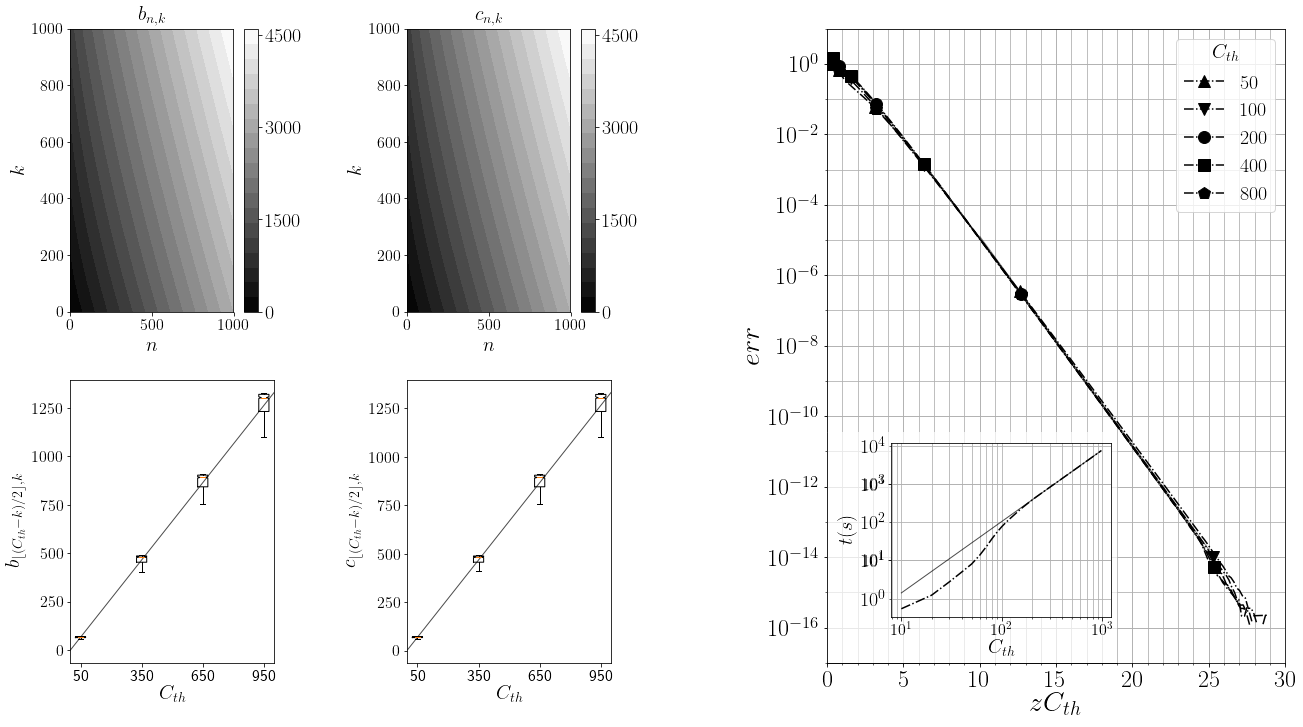

In [38]:
# root distribution of xn and yn
mat_contents = loadmat('xn.mat')
xn = mat_contents['xn']
mat_contents = loadmat('yn.mat')
yn = mat_contents['yn']
an = np.real(xn)
bn = np.imag(xn)
cn = np.imag(yn)
cth_max = cn.shape[0]

    
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2, 4), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2, 4), (1, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2, 4), (1, 1), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((2, 2), (0, 1), rowspan=2, colspan=1)

cs = ax1.contourf(bn, levels=np.linspace(0, 4600, 20), cmap=plt.cm.gray)
# cs2 = ax1.contour(cs, levels=np.linspace(0, 4500, 10), colors='k')
# ax1.clabel(cs2, cs2.levels, fmt='%d', fontsize=fontsize*0.5, colors='k')
cbar = fig.colorbar(cs, ax=ax1, shrink=1, ticks=np.linspace(0, 4500, 4))
# cbar.add_lines(cs2)
cbar.ax.tick_params(labelsize=fontsize*0.5)
ax1.set_title('$b_{n,k}$', size=fontsize*0.5)
ax1.set_xlabel('$n$', size=fontsize*0.5)
ax1.set_ylabel('$k$', size=fontsize*0.5)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.4)
plt.yticks(fontsize=fontsize*0.4)
# # dbg 
# for tclc in cs.collections:
#     tv = tclc.get_paths()[0].vertices
# #     ax1.plot(tv[:, 0], tv[:, 1])
#     spf.fit_line(ax1, tv[:, 0], tv[:, 1], 0, cth_max, ifprint=1, linestyle='-', linewidth=1)
    
cs = ax2.contourf(cn, levels=np.linspace(0, 4600, 20), cmap=plt.cm.gray)
# cs2 = ax2.contour(cs, levels=np.linspace(0, 4500, 10), colors='k')
cbar = fig.colorbar(cs, ax=ax2, shrink=1, ticks=np.linspace(0, 4500, 4))
# cbar.add_lines(cs2)
cbar.ax.tick_params(labelsize=fontsize*0.5)
ax2.set_title('$c_{n,k}$', size=fontsize*0.5)
ax2.set_xlabel('$n$', size=fontsize*0.5)
ax2.set_ylabel('$k$', size=fontsize*0.5)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.4)
plt.yticks(fontsize=fontsize*0.4)



# plot the boxplot
bn_lst = []
cn_lst = []
cth_lst = np.arange(50, cth_max, 300)
for cthi in cth_lst:
    tbn = []
    tcn = []
    for ki in np.arange(cthi):
        ni = np.int(np.floor((cthi-ki)/2.3))
        tbn.append(bn[ki, ni])
        tcn.append(cn[ki, ni])
    bn_lst.append(np.array(tbn))
    cn_lst.append(np.array(tcn))

_ = ax3.boxplot(bn_lst, positions=cth_lst, widths=50, showfliers=False, notch=True)
_ = ax4.boxplot(cn_lst, positions=cth_lst, widths=50, showfliers=False, notch=True)

# plot the min line
bn_lst = []
cn_lst = []
cth_lst = np.arange(1, cth_max)
for cthi in cth_lst:
    tbn = []
    tcn = []
    for ki in np.arange(cthi):
        ni = np.int(np.floor((cthi-ki)/2.3))
        tbn.append(bn[ki, ni])
        tcn.append(cn[ki, ni])
    bn_lst.append(np.array(tbn))
    cn_lst.append(np.array(tcn))
    
# bn_min = np.array([np.min(t1) for t1 in bn_lst])
# spf.fit_line(ax3, cth_lst, bn_min, 0, cth_max, ifprint=1, linestyle='-', linewidth=1)
bn_mean = np.array([np.mean(t1) for t1 in bn_lst])
spf.fit_line(ax3, cth_lst, bn_mean, 0, cth_max, ifprint=1, linestyle='-', linewidth=1)
ax3.set_xlim(0, cth_max)
ax3.set_xlabel('$C_{th}$')
ax3.set_ylabel('$b_{\\lfloor (C_{th}-k)/2 \\rfloor , k}$')
plt.sca(ax3)
plt.xticks(fontsize=fontsize*0.4)
plt.yticks(fontsize=fontsize*0.4)

# cn_min = np.array([np.min(t1) for t1 in cn_lst])
# spf.fit_line(ax4, cth_lst, cn_min, 0, cth_max, ifprint=1, linestyle='-', linewidth=1)
cn_mean = np.array([np.mean(t1) for t1 in cn_lst])
spf.fit_line(ax4, cth_lst, cn_mean, 0, cth_max, ifprint=1, linestyle='-', linewidth=1)
ax4.set_xlim(0, cth_max)
ax4.set_xlabel('$C_{th}$')
ax4.set_ylabel('$c_{\\lfloor (C_{th}-k)/2 \\rfloor , k}$')
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.4)
plt.yticks(fontsize=fontsize*0.4)
plt.tight_layout()



# plot the err -- z*Cth
mat_contents = loadmat('convergence_z.mat')
R1 = mat_contents['R1'][0]
Uxyz = mat_contents['Uxyz'][0]
Uxyz1 = mat_contents['Uxyz1'][0]
Uxyz2 = mat_contents['Uxyz2'][0]
b = mat_contents['b'][0]
phi1 = mat_contents['phi1'][0]
threshold = mat_contents['threshold'][0]
threshold_list = mat_contents['threshold_list'][0]
uPhi = mat_contents['uPhi'][0]
uR = mat_contents['uR'][0]
u_struct = mat_contents['u_struct'][0]
uz = mat_contents['uz'][0]
z1 = mat_contents['z1'][0]

t_z_cth = np.array([t1 * z1 for t1 in threshold_list[:-1]])
residual = np.vstack([np.abs((t1['uz']-u_struct[-1]['uz'])/u_struct[-1]['uz']) for t1 in u_struct[:-1]])
for tx, ty, t_th, marker in zip(t_z_cth[2:], residual[2:], threshold_list[2:-1], spf.markerstyle_list):
    ax5.semilogy(tx, ty, linestyle='-.', marker=marker, markevery=200,
             label='$%d$' % t_th, ms=fontsize*0.3, color='k')
fit_para = spf.fit_semilogy(ax5, t_z_cth.flatten(), residual.flatten(), 10, 25, ifprint=1, linestyle='-', 
                            linewidth=1, color='k', alpha=0.5)
ax5.set_xlim(0, 30)
ax5.xaxis.set_major_locator(MultipleLocator(5))
ax5.xaxis.set_minor_locator(MultipleLocator(1))
ax5.set_ylim(1e-17, 1e1)
ax5.yaxis.set_major_locator(ticker.LogLocator(base=100))
ax5.yaxis.set_minor_locator(ticker.LogLocator(numticks=20))
ax5.yaxis.set_ticklabels([], minor=True)
ax5.legend(loc=0, fontsize=fontsize*0.5)
ax5.get_legend().set_title('$C_{th}$', prop = {'size':fontsize*0.5})
ax5.set_xlabel('$zC_{th}$', fontsize=fontsize*0.7)
ax5.set_ylabel('$err$', fontsize=fontsize*0.7)
plt.sca(ax5)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.grid(True, which='both')
plt.tight_layout()

ax5_pst = ax5.get_position()
ax7 = plt.axes([ax5_pst.x0, ax5_pst.y0, .218, .305])
ax7.patch.set_alpha(0.7)
ax7.axes.get_xaxis().set_visible(False)
ax7.axes.get_yaxis().set_visible(False)
ax7.spines['right'].set_color('none')
ax7.spines['top'].set_color('none')

mat_contents = loadmat('num_ana_speed.mat')
dt_all = mat_contents['dt_all'].T[0]
cth_all = mat_contents['cth_all'].T[0]
ax6 = plt.axes([.68, .165, .165, .23])
ax6.loglog(cth_all, dt_all, 'k-.', ms=fontsize*0.4)
spf.fit_power_law(ax6, cth_all, dt_all, 300, 1000, linestyle='-', linewidth=1, extendline=True)
ax6.yaxis.set_major_locator(ticker.LogLocator(base=10))
ax6.yaxis.set_minor_locator(ticker.LogLocator(numticks=20))
# ax6.yaxis.set_ticklabels([], minor=True)
ax6.set_xlabel('$C_{th}$', size=fontsize*0.5, color='k')
ax6.set_ylabel('$t(s)$', size=fontsize*0.5)
plt.sca(ax6)
plt.xticks(fontsize=fontsize*0.4)
plt.yticks(fontsize=fontsize*0.4)
plt.grid(True, which='both')



log(y) = 0.930549 + -0.586661 * x in range (5.0, 24.995152288027565)
ln(y) = 2.142669 + -1.350837 * x in range (5.0, 24.995152288027565)


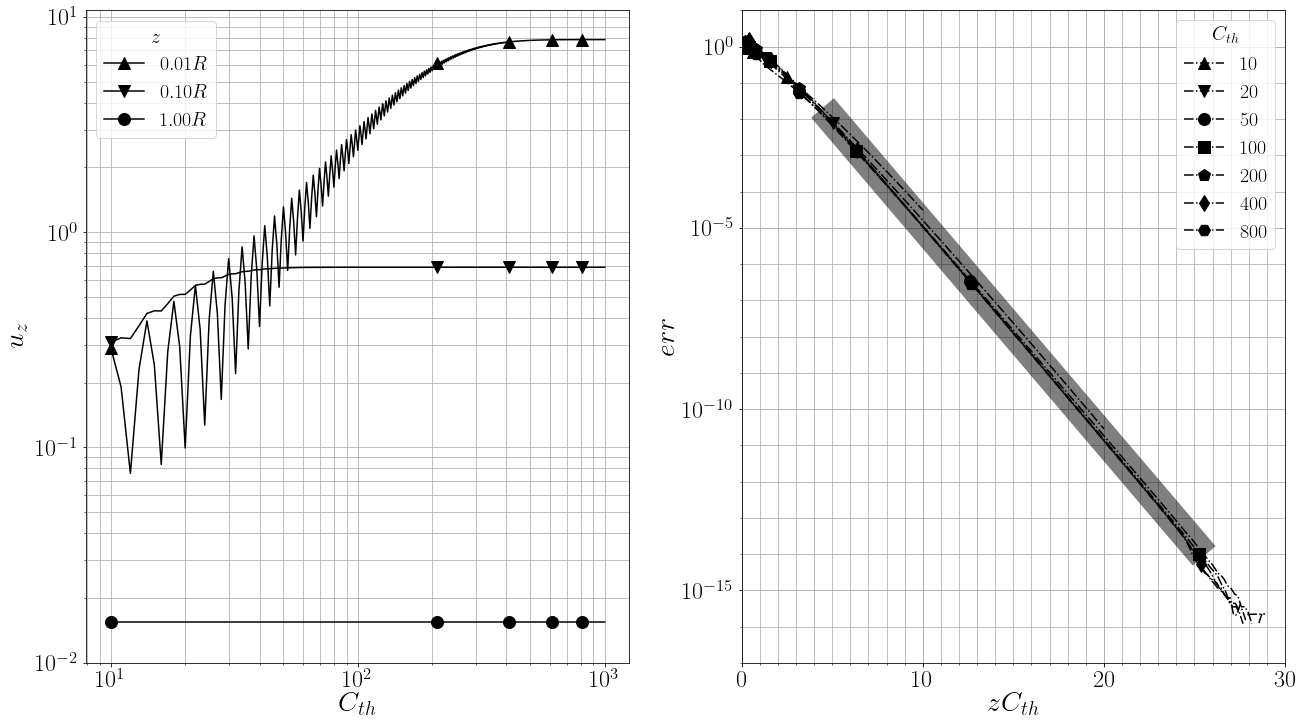

In [7]:
mat_contents = loadmat('convergence_th.mat')
R1 = mat_contents['R1'][0]
Uxyz = mat_contents['Uxyz'][0]
Uxyz1 = mat_contents['Uxyz1'][0]
Uxyz2 = mat_contents['Uxyz2'][0]
b = mat_contents['b'][0]
phi1 = mat_contents['phi1'][0]
threshold = mat_contents['threshold'][0]
threshold_list = mat_contents['threshold_list'][0]
uPhi = mat_contents['uPhi'][0]
uR = mat_contents['uR'][0]
u_struct = mat_contents['u_struct'][0]
uz = mat_contents['uz'][0]
z1 = mat_contents['z1'][0]

temp = np.vstack([t1['uz'] for t1 in u_struct])
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for ty, tz, marker in zip(temp.T[1:], z1[1:], spf.markerstyle_list):
    ax1.loglog(threshold_list, ty, linestyle='-', marker=marker, markevery=200,
             label='$%.2fR$' % tz, ms=fontsize*0.3, color='k')
ax1.yaxis.set_ticks(np.array((10**-2, 10**-1, 10**0, 10**1)))
ax1.legend(loc=0, fontsize=fontsize*0.5)
ax1.get_legend().set_title('$z$', prop = {'size':fontsize*0.5})
ax1.set_xlabel('$C_{th}$', fontsize=fontsize*0.7)
ax1.set_ylabel('$u_z$', fontsize=fontsize*0.7)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.grid(True, which='both')

mat_contents = loadmat('convergence_z.mat')
R1 = mat_contents['R1'][0]
Uxyz = mat_contents['Uxyz'][0]
Uxyz1 = mat_contents['Uxyz1'][0]
Uxyz2 = mat_contents['Uxyz2'][0]
b = mat_contents['b'][0]
phi1 = mat_contents['phi1'][0]
threshold = mat_contents['threshold'][0]
threshold_list = mat_contents['threshold_list'][0]
uPhi = mat_contents['uPhi'][0]
uR = mat_contents['uR'][0]
u_struct = mat_contents['u_struct'][0]
uz = mat_contents['uz'][0]
z1 = mat_contents['z1'][0]
mat_contents = loadmat('num_ana_speed.mat')
dt_all = mat_contents['dt_all'].T[0]
dt_ana = mat_contents['dt_ana'].T[0]
dt_num = mat_contents['dt_num'].T[0]
cth_all = mat_contents['cth_all'].T[0]
cth = mat_contents['cth'].T[0]
nnode = mat_contents['nnode'].T[0]

t_z_cth = np.array([t1 * z1 for t1 in threshold_list[:-1]])
residual = np.vstack([np.abs((t1['uz']-u_struct[-1]['uz'])/u_struct[-1]['uz']) for t1 in u_struct[:-1]])
for tx, ty, t_th, marker in zip(t_z_cth, residual, threshold_list[:-1], spf.markerstyle_list):
    ax2.semilogy(tx, ty, linestyle='-.', marker=marker, markevery=200,
             label='$%d$' % t_th, ms=fontsize*0.3, color='k')
fit_para = spf.fit_semilogy(ax2, t_z_cth.flatten(), residual.flatten(), 5, 25, ifprint=1, linestyle='-', 
                            linewidth=30, color='k', alpha=0.5)
ax2.set_xlim(0, 30)
ax2.xaxis.set_major_locator(MultipleLocator(10))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.set_ylim(1e-17, 1e1)
ax2.yaxis.set_major_locator(ticker.LogLocator(base=100000))
ax2.yaxis.set_minor_locator(ticker.LogLocator(numticks=20))
ax2.yaxis.set_ticklabels([], minor=True)
ax2.legend(loc=0, fontsize=fontsize*0.5)
ax2.get_legend().set_title('$C_{th}$', prop = {'size':fontsize*0.5})
ax2.set_xlabel('$zC_{th}$', fontsize=fontsize*0.7)
ax2.set_ylabel('$err$', fontsize=fontsize*0.7)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.grid(True, which='both')
plt.tight_layout()




In [65]:
# check convergence1 with b

# get data 1
dir_name1 = 'test_L_ds'
dir_name2 = 'err_b'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case2_L*_ds*_check_b*_u.mat' % t_dir)

b_list = []        # location of x_f
errx_b = []          # error of velocity
erry_b = []          # error of velocity
errz_b = []          # error of velocity
errx1_b = []          # error of velocity
erry1_b = []          # error of velocity
errz1_b = []          # error of velocity

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    Li, dsi, bi = scanf('case2_L%f_ds%f_check_b%f_u.mat', os.path.basename(mati))
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    t_nodes = mat_contents['nodes']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni

    idx = np.abs(t_nodes[:, 2]) < 1
    ni = np.sum(idx)
    tmp = np.sort(np.linalg.norm(u11_ana.reshape(-1, 3) - u11_num.reshape(-1, 3), axis=1)[idx])
    errxi1 = np.linalg.norm(tmp[:]) / ni
    tmp = np.sort(np.linalg.norm(u21_ana.reshape(-1, 3) - u21_num.reshape(-1, 3), axis=1)[idx])
    erryi1 = np.linalg.norm(tmp[:]) / ni
    tmp = np.sort(np.linalg.norm(u31_ana.reshape(-1, 3) - u31_num.reshape(-1, 3), axis=1)[idx])
    errzi1 = np.linalg.norm(tmp[:]) / ni
    
    b_list.append(bi)
    errx_b.append(errxi)
    erry_b.append(erryi)
    errz_b.append(errzi)
    errx1_b.append(errxi1)
    erry1_b.append(erryi1)
    errz1_b.append(errzi1)
    
data_err_b = pd.DataFrame({'b': np.hstack(b_list), 
                         'errx_b': np.hstack(errx_b), 
                         'erry_b': np.hstack(erry_b), 
                         'errz_b': np.hstack(errz_b), 
                         'errx1_b': np.hstack(errx1_b), 
                         'erry1_b': np.hstack(erry1_b), 
                         'errz1_b': np.hstack(errz1_b), })\
               .pivot_table(index=['b'])
errx_b = data_err_b.errx_b
erry_b = data_err_b.erry_b
errz_b = data_err_b.errz_b
errx1_b = data_err_b.errx1_b
erry1_b = data_err_b.erry1_b
errz1_b = data_err_b.errz1_b


In [9]:
# check convergence of sphere
dir_name1 = 'sphereTest'
t_dir = os.path.join(PWD, dir_name1)
txt_names = glob.glob('%s/*.txt' % t_dir)

epsilon = []
nnode = []
resistance = []
rs = []

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'force nodes'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'epsilon: '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    epsilon.append(temp1)
    
    text_headle = 'sphere radius: '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    rs.append(temp1)
    
    text_headle = 'Resultant at z axis is \[ '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=3)
    resistance.append(temp1)

resistance = np.vstack(resistance).T
data_sphereInPipe = pd.DataFrame({'epsilon': np.hstack(epsilon), 
                    'nnode': np.hstack(nnode), 
                    'rs': np.hstack(rs), 
                    'Fx': resistance[0], 
                    'Fy': resistance[1], 
                    'Fz': resistance[2]})\
        .pivot_table(index=['nnode', 'epsilon'], columns=['rs'])

resFz = data_sphereInPipe.Fz

y = 0.000232 + 0.000001 * x in range (202, 25098)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


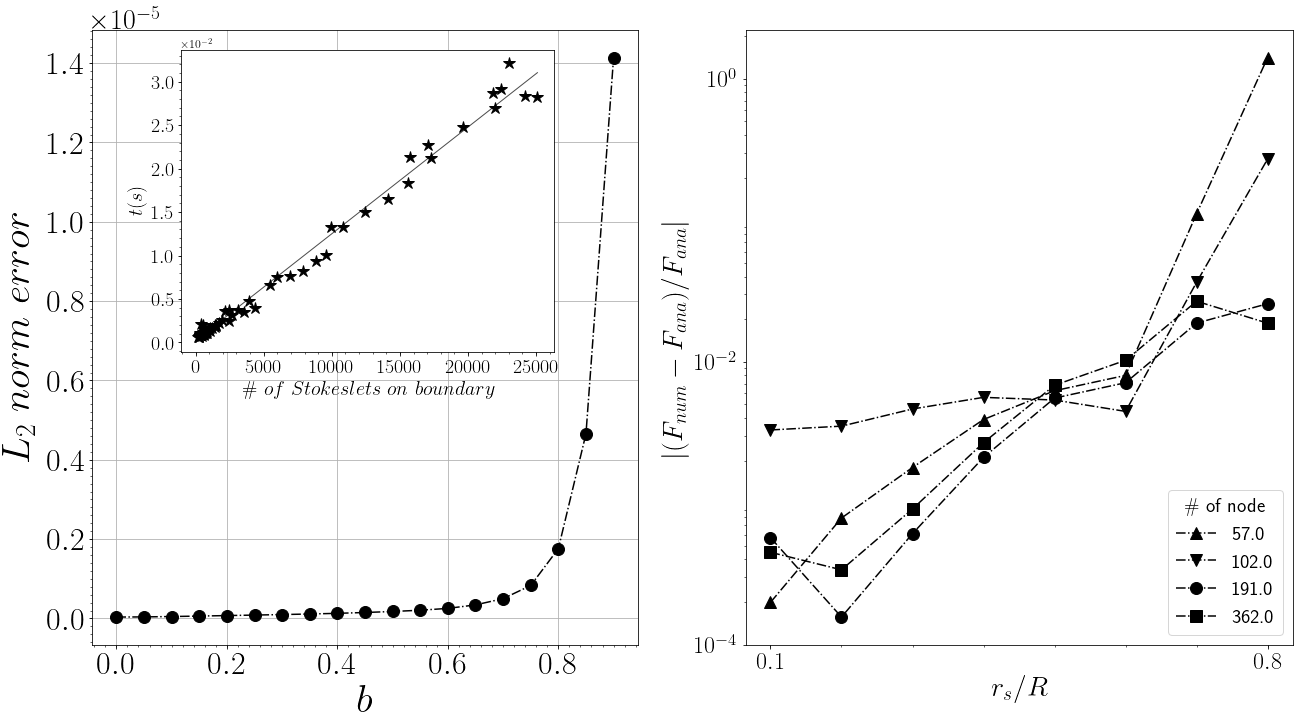

In [10]:
# err-vs
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax4 = plt.axes([.147, .515, .28, .4])

ax1.plot(errx_b.index, double(errx_b.values), 'ko-.', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax1.set_xlabel('$b$', size=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0000002))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='major')

mat_contents = loadmat('num_ana_speed.mat')
dt_num = mat_contents['dt_num'].T[0] * 24 / 1000 # 24 cores, 1000 nodes. 
nnode = mat_contents['nnode'].T[0]
ax4.plot(nnode, double(dt_num), 'k*', ms=fontsize*0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
spf.fit_line(ax4, nnode, dt_num, 0, 50000, ifprint=1, linestyle='-', linewidth=1)
ax4.set_ylabel('$t(s)$', size=fontsize*0.5)
ax4.set_xlabel('$\#\ of\ Stokeslets\ on\ boundary$', size=fontsize*0.5)
ax4.yaxis.get_offset_text().set_fontsize(fontsize*0.3)
ax4.xaxis.set_minor_locator(MultipleLocator(1000))
ax4.yaxis.set_minor_locator(MultipleLocator(0.001))
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
# plt.grid(True, which='major')

ana_rs = np.arange(0, 0.9, 0.1)
ana_Fz = np.array([1.000, 1.263, 1.680, 2.371, 3.596, 5.970, 11.135, 24.955, 73.555])
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'd-.', '<-.', '>-.']
es = resFz.index.levels[1][[2]]
for nnode, lsi in zip(resFz.index.levels[0][[0, 1, 2, 3]], linestyle_list):
#     for nnode in resFz.index.levels[0]:
    tx = resFz.loc[nnode].loc[es]
    ty = tx.columns.values
    ax2.plot(ty, np.abs((tx.values[0] - ana_Fz[1:])/ana_Fz[1:]), lsi, label=nnode, ms=fontsize*0.3, color='k')
ax2.set_yscale('log')
ax2.xaxis.set_ticks(np.array((0.1, 0.8)))
ax2.xaxis.set_minor_locator(MultipleLocator(1e-1))
ax2.yaxis.set_ticks(np.array((10**-4, 10**-2, 10**0)))
ax2.legend(loc=4, fontsize=fontsize*0.5)
ax2.get_legend().set_title('\# of node', prop = {'size':fontsize*0.5})
ax2.set_xlabel('$r_s/R$', fontsize=fontsize*0.7)
ax2.set_ylabel('$|(F_{num}-F_{ana})/F_{ana}|$', fontsize=fontsize*0.7)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.tight_layout()



y = 0.000232 + 0.000001 * x in range (202, 25098)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


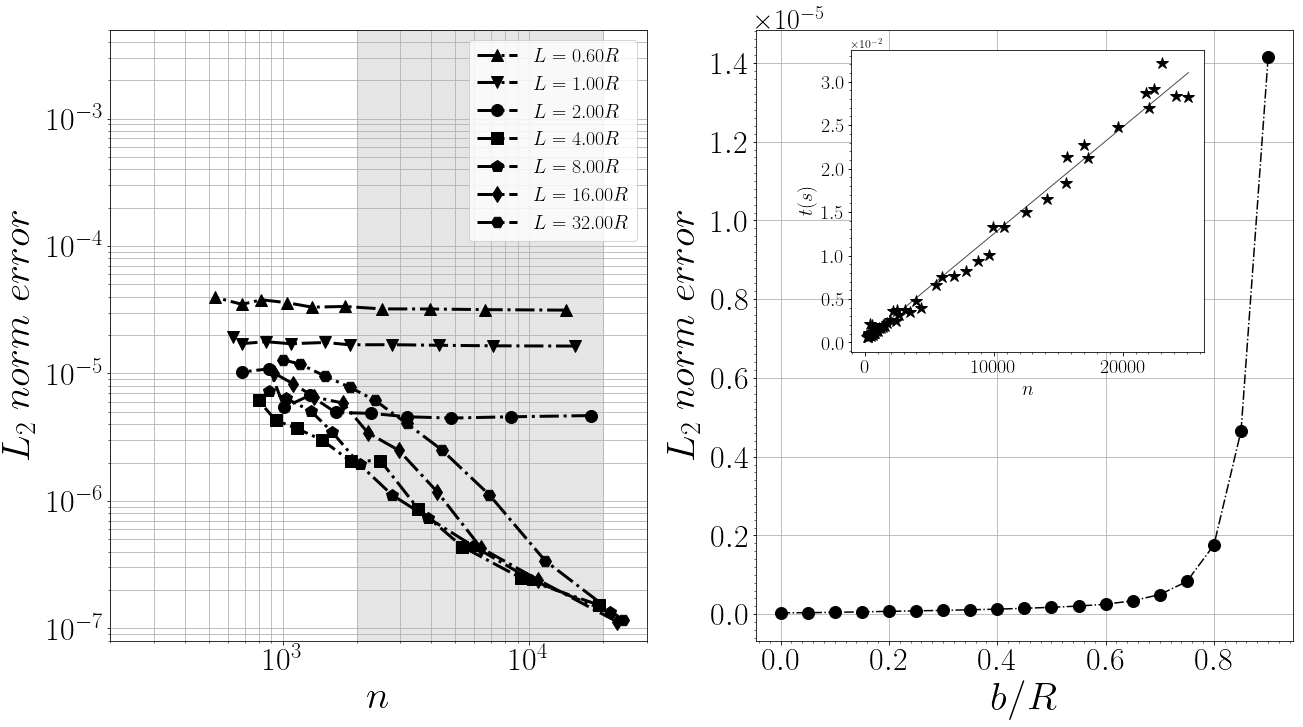

In [28]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 1)
ax4 = plt.axes([.65, .515, .265, .4])

ax1.plot(errx_b.index, double(errx_b.values), 'ko-.', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax1.set_xlabel('$b/R$', size=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0000002))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='major')

mat_contents = loadmat('num_ana_speed.mat')
dt_num = mat_contents['dt_num'].T[0] * 24 / 1000 # 24 cores, 1000 nodes. 
nnode = mat_contents['nnode'].T[0]
ax4.plot(nnode, double(dt_num), 'k*', ms=fontsize*0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
spf.fit_line(ax4, nnode, dt_num, 0, 50000, ifprint=1, linestyle='-', linewidth=1)
ax4.set_ylabel('$t(s)$', size=fontsize*0.5)
ax4.set_xlabel('$n$', size=fontsize*0.5)
ax4.yaxis.get_offset_text().set_fontsize(fontsize*0.3)
ax4.xaxis.set_minor_locator(MultipleLocator(1000))
ax4.yaxis.set_minor_locator(MultipleLocator(0.001))
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)

# 1/ds-err
bi = errx.columns[[5]].values
t0 = errx[bi]
t1 = errx1[bi]
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'p-.', 'd-.', 'H-.']
for Li, lsi in zip(t1.index.levels[0], linestyle_list):
    ty = t0.loc[Li]
#     tx = 1 / ty.index
    tx = data_detail.loc[Li].nnode.values
    ty = t0.loc[Li].values.T[0]
    ty1 = t1.loc[Li].values.T[0]
    ax2.loglog(tx, ty, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     ax3.loglog(tx, ty1, '*-.', label='L=%.2f' % Li, linewidth=3)
#     spf.fit_power_law(ax2, tx, ty, 13, 35, linestyle='-', linewidth=5)
ax2.legend(fontsize=fontsize*0.5, loc=0)
ax2.set_xlabel('$n$', size=fontsize)
ax2.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax2.set_xlim(2e2, 3e4)
# # ax2.set_ylim(1e-2, 1e2)
# # ax2.loglog((15, 40), (1e-5, 10**((np.log10(15 / 40))*1.3 + np.log10(1e-5))), 'k-', linewidth=5)
# # ax2.loglog((13, 35), (2e-6, 10**((np.log10(13 / 35))*1.3 + np.log10(2e-6))), 'k-', linewidth=5)
# xticks = np.array([2e2, 1e3, 1e4, 3e4])
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
tylim = (8e-8, 0.005)
ax2.fill_between(np.array((2000, 20000)), *tylim, color='k', alpha=0.1)
ax2.set_ylim(tylim)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


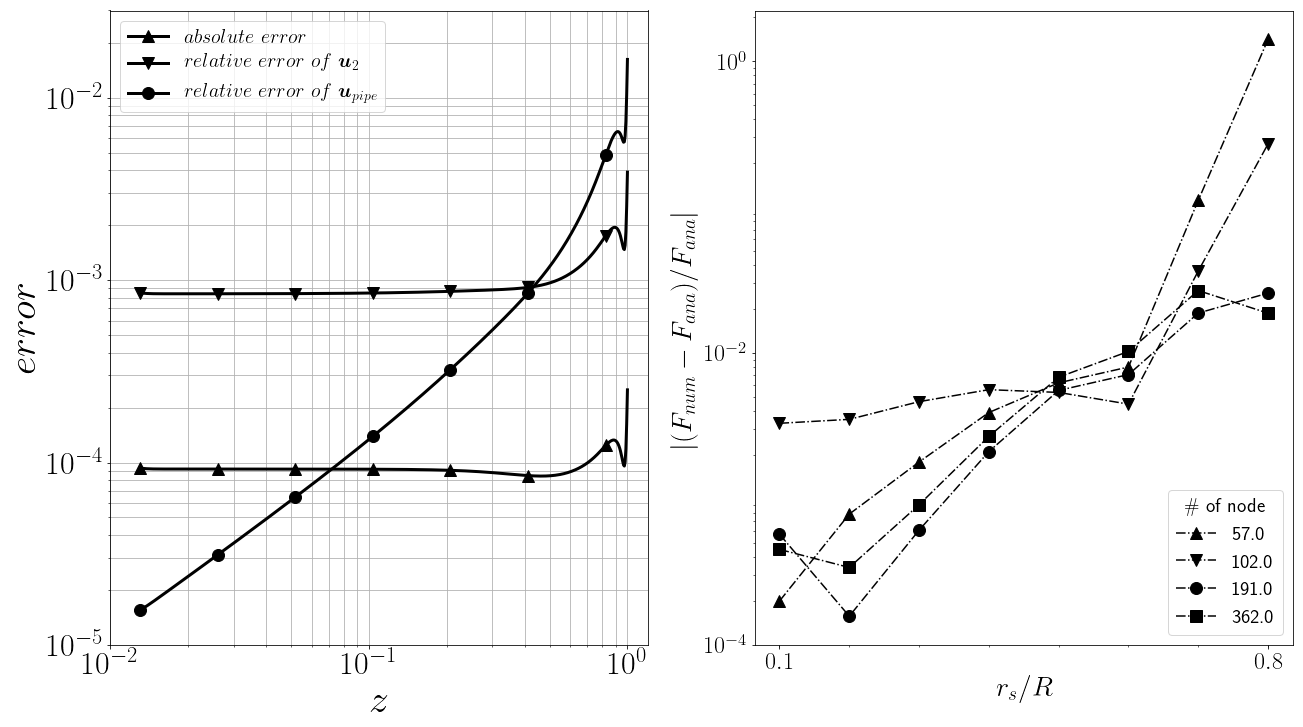

In [12]:
# err-vs
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

rel_err1 = np.abs((num_uz - ana_uz) / ana_uz)
rel_err2 = np.abs((num_uz - ana_uz) / (ana_uz - uz_inf))
rel_err3 = np.abs(num_uz - ana_uz)
# rel_err = np.abs((num_uz - ana_uz) / ana_uz)
# rel_err2 = np.abs((num_uz - ana_uz))
# rel_err2 = np.abs(ana_uz - uz_inf)

ax1.loglog(convergence_z1, rel_err3, '^-', linewidth=3, label='$absolute\ error$', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(convergence_z1, rel_err2, 'v-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{2}', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(convergence_z1, rel_err1, 'o-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{pipe}$', color='k', ms=fontsize*0.3, markevery=100)
ax1.legend(fontsize=fontsize*0.5, loc=2)
ax1.set_xlabel('$z$', size=fontsize)
ax1.set_ylabel('$error$', size=fontsize)
ax1.set_xlim(0.01, 1.2)
ax1.set_ylim(1e-5, 3e-2)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


ana_rs = np.arange(0, 0.9, 0.1)
ana_Fz = np.array([1.000, 1.263, 1.680, 2.371, 3.596, 5.970, 11.135, 24.955, 73.555])
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'd-.', '<-.', '>-.']
es = resFz.index.levels[1][[2]]
for nnode, lsi in zip(resFz.index.levels[0][[0, 1, 2, 3]], linestyle_list):
#     for nnode in resFz.index.levels[0]:
    tx = resFz.loc[nnode].loc[es]
    ty = tx.columns.values
    ax2.plot(ty, np.abs((tx.values[0] - ana_Fz[1:])/ana_Fz[1:]), lsi, label=nnode, ms=fontsize*0.3, color='k')
ax2.set_yscale('log')
ax2.xaxis.set_ticks(np.array((0.1, 0.8)))
ax2.xaxis.set_minor_locator(MultipleLocator(1e-1))
ax2.yaxis.set_ticks(np.array((10**-4, 10**-2, 10**0)))
ax2.legend(loc=4, fontsize=fontsize*0.5)
ax2.get_legend().set_title('\# of node', prop = {'size':fontsize*0.5})
ax2.set_xlabel('$r_s/R$', fontsize=fontsize*0.7)
ax2.set_ylabel('$|(F_{num}-F_{ana})/F_{ana}|$', fontsize=fontsize*0.7)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.tight_layout()



In [23]:
# check convergence1

# get data 1
dir_name1 = 'test_L_ds'
# dir_name2 = 'case6d5'
dir_name2 = 'case8'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case*_L*_ds*_check_b*_u.mat' % t_dir)

L = []             # pipe length
ds = []            # delta length
b_list = []        # location of x_f
threshold = []     # cut of threshold
errx = []          # error of velocity
erry = []          # error of velocity
errz = []          # error of velocity
errx1 = []          # error of velocity
erry1 = []          # error of velocity
errz1 = []          # error of velocity
nnode = []         # amount of nodes

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    _, Li, dsi, bi = scanf('case%s_L%f_ds%f_check_b%f_u.mat', os.path.basename(mati))
    cthi = kwargs['th'][0]
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    t_nodes = mat_contents['nodes']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni
    
#     idx = np.isclose(np.linalg.norm(t_nodes[:, :2], axis=1), 1)
    idx = np.abs(t_nodes[:, 2]) < 1
    ni = np.sum(idx)
    tmp = np.sort(np.linalg.norm(u11_ana.reshape(-1, 3) - u11_num.reshape(-1, 3), axis=1)[idx])
    errxi1 = np.linalg.norm(tmp[:]) / ni
    tmp = np.sort(np.linalg.norm(u21_ana.reshape(-1, 3) - u21_num.reshape(-1, 3), axis=1)[idx])
    erryi1 = np.linalg.norm(tmp[:]) / ni
    tmp = np.sort(np.linalg.norm(u31_ana.reshape(-1, 3) - u31_num.reshape(-1, 3), axis=1)[idx])
    errzi1 = np.linalg.norm(tmp[:]) / ni
        
    L.append(Li)
    ds.append(dsi)
    b_list.append(bi)
    threshold.append(cthi)
    errx.append(errxi)
    erry.append(erryi)
    errz.append(errzi)
    errx1.append(errxi1)
    erry1.append(erryi1)
    errz1.append(errzi1)
    
data_err = pd.DataFrame({'L': np.hstack(L), 
                         'ds': np.hstack(ds), 
                         'b': np.hstack(b_list), 
                         'cth': np.hstack(threshold),
                         'errx': np.hstack(errx), 
                         'erry': np.hstack(erry), 
                         'errz': np.hstack(errz), 
                         'errx1': np.hstack(errx1), 
                         'erry1': np.hstack(erry1), 
                         'errz1': np.hstack(errz1), })\
               .pivot_table(index=['L', 'ds'], columns=['b'])
errx = data_err.errx
erry = data_err.erry
errz = data_err.errz
errx1 = data_err.errx1
erry1 = data_err.erry1
errz1 = data_err.errz1

# get data 2
txt_names = glob.glob('%s/*.txt' % t_dir)
L = []             # pipe length
ds = []            # delta length
nnode = []         # amount of nodes
threshold = []     # cut of threshold

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'pipe length:'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    L.append(temp1)
    
    text_headle = 'delta length, epsilon and factor of pipe are'
    temp2 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    ds.append(temp2)
    
    text_headle = 'Stokeslets in pipe prepare, contain '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'threshold of series is '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    threshold.append(temp1)

data_detail = pd.DataFrame({'L': np.hstack(L), 
                    'ds': np.hstack(ds), 
                    'nnode': np.hstack(nnode), 
                    'cth': np.hstack(threshold), })\
        .pivot_table(index=['L', 'ds'])
nnode = data_detail.nnode


y = 0.000232 + 0.000001 * x in range (202, 25098)


(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04]),
 <a list of 6 Text yticklabel objects>)

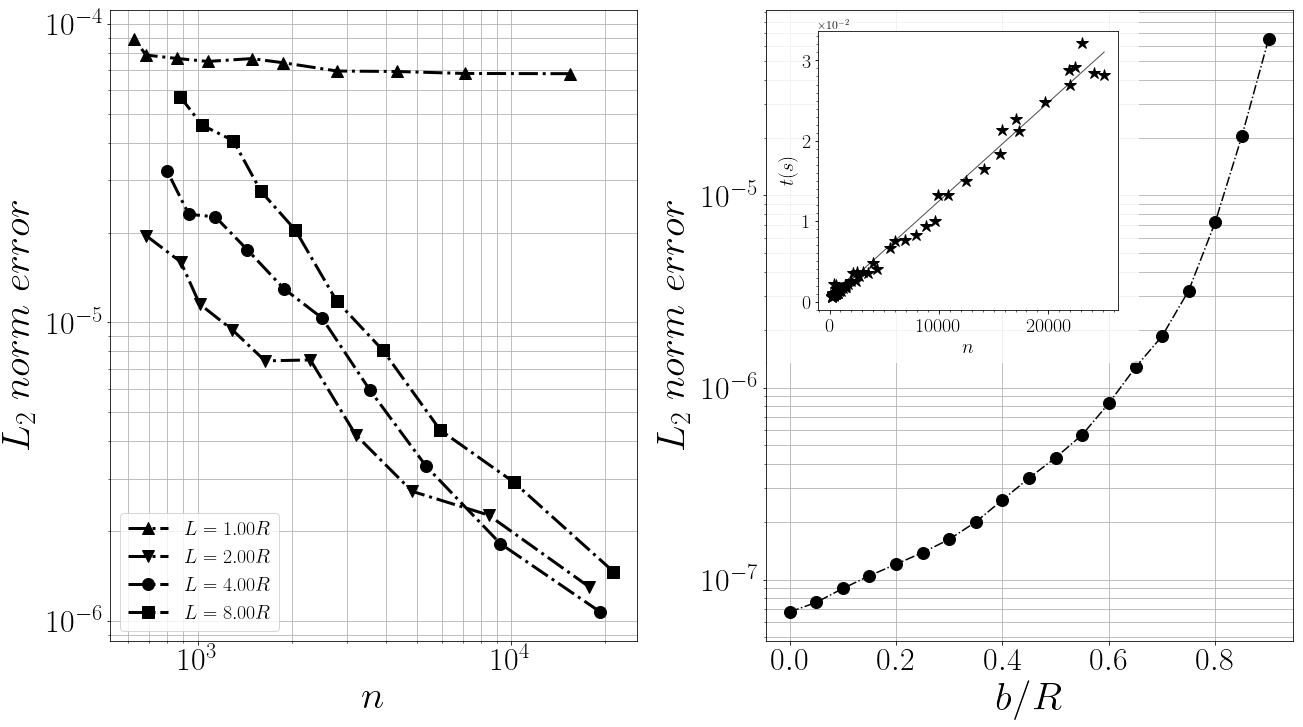

In [66]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 1)

ax1.semilogy(errx1_b.index, double(errx1_b.values), 'ko-.', ms=fontsize*0.3)
# ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax1.set_xlabel('$b/R$', size=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
# ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.0000002))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')

# 1/ds-err
bi = errx.columns[[5]].values
t0 = errx[bi]
t1 = errz1[bi]
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'p-.', 'd-.', 'H-.', 
                  '1-.', '2-.', '3-.', '4-.', '8-.', 'P-.', '*-.', 
                  'h-.', '+-.', 'x-.', 'X-.', 'D-.', '|-.', '_-.', ]
for Li, lsi in zip(t1.index.levels[0][1:5], linestyle_list):
    ty = t0.loc[Li]
#     tx = 1 / ty.index
    tx = data_detail.loc[Li].nnode.values
    ty0 = t0.loc[Li].values.T[0]
    ty1 = t1.loc[Li].values.T[0]
#     ax2.loglog(tx, ty0, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
    ax2.loglog(tx, ty1, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     spf.fit_power_law(ax2, tx, ty, 13, 35, linestyle='-', linewidth=5)
ax2.legend(fontsize=fontsize*0.5, loc=0)
ax2.set_xlabel('$n$', size=fontsize)
ax2.set_ylabel('$L_2\ norm\ error$', size=fontsize)
# ax2.set_xlim(9e2, 3e4)
# ax2.set_ylim(1e-8, 1e-3)
# # ax2.loglog((15, 40), (1e-5, 10**((np.log10(15 / 40))*1.3 + np.log10(1e-5))), 'k-', linewidth=5)
# # ax2.loglog((13, 35), (2e-6, 10**((np.log10(13 / 35))*1.3 + np.log10(2e-6))), 'k-', linewidth=5)
# xticks = np.array([2e2, 1e3, 1e4, 3e4])
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
tylim = (8e-8, 0.005)
# ax2.fill_between(np.array((2000, 20000)), *tylim, color='k', alpha=0.1)
# ax2.set_ylim(tylim)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


ax5_pst = ax1.get_position()
ax5_pst_y0 = 0.5
ax7 = plt.axes([ax5_pst.x0, ax5_pst_y0, .28, ax5_pst.y1-ax5_pst_y0])
ax7.patch.set_alpha(0.8)
ax7.axes.get_xaxis().set_visible(False)
ax7.axes.get_yaxis().set_visible(False)
ax7.spines['right'].set_color('none')
ax7.spines['bottom'].set_color('none')

mat_contents = loadmat('num_ana_speed.mat')
dt_num = mat_contents['dt_num'].T[0] * 24 / 1000 # 24 cores, 1000 nodes. 
nnode = mat_contents['nnode'].T[0]

ax4 = plt.axes([.625, .57, .225, .37])
ax4.plot(nnode, double(dt_num), 'k*', ms=fontsize*0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
spf.fit_line(ax4, nnode, dt_num, 0, 50000, ifprint=1, linestyle='-', linewidth=1)
ax4.set_ylabel('$t(s)$', size=fontsize*0.5)
ax4.set_xlabel('$n$', size=fontsize*0.5)
ax4.yaxis.get_offset_text().set_fontsize(fontsize*0.3)
ax4.xaxis.set_minor_locator(MultipleLocator(1000))
ax4.yaxis.set_minor_locator(MultipleLocator(0.001))
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)


In [15]:
# check convergence1

# get data 1
dir_name1 = 'test_L_ds'
dir_name2 = 'case7'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case*_f*_check_b*_u.mat' % t_dir)

stokesletsInPipe_pipeFactor = []             # stokesletsInPipe_pipeFactor length
# ds = []            # delta length
b_list = []        # location of x_f
threshold = []     # cut of threshold
errx = []          # error of velocity
erry = []          # error of velocity
errz = []          # error of velocity
errx1 = []          # error of velocity
erry1 = []          # error of velocity
errz1 = []          # error of velocity
nnode = []         # amount of nodes

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    _, fcti, bi = scanf('case%s_f%f_check_b%f_u.mat', os.path.basename(mati))
    cthi = kwargs['th'][0]
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    t_nodes = mat_contents['nodes']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni
    
#     idx = np.isclose(np.linalg.norm(t_nodes[:, :2], axis=1), 1)
    idx = np.abs(t_nodes[:, 2]) < 0.5
    ni = np.sum(idx)
    tmp = np.sort(np.linalg.norm(u11_ana.reshape(-1, 3) - u11_num.reshape(-1, 3), axis=1)[idx])
    errxi1 = np.linalg.norm(tmp[:]) / ni
    tmp = np.sort(np.linalg.norm(u21_ana.reshape(-1, 3) - u21_num.reshape(-1, 3), axis=1)[idx])
    erryi1 = np.linalg.norm(tmp[:]) / ni
    tmp = np.sort(np.linalg.norm(u31_ana.reshape(-1, 3) - u31_num.reshape(-1, 3), axis=1)[idx])
    errzi1 = np.linalg.norm(tmp[:]) / ni
        
    stokesletsInPipe_pipeFactor.append(fcti)
    b_list.append(bi)
    threshold.append(cthi)
    errx.append(errxi)
    erry.append(erryi)
    errz.append(errzi)
    errx1.append(errxi1)
    erry1.append(erryi1)
    errz1.append(errzi1)
    
data_err = pd.DataFrame({'fct': np.hstack(stokesletsInPipe_pipeFactor), 
                         'b': np.hstack(b_list), 
                         'cth': np.hstack(threshold),
                         'errx': np.hstack(errx), 
                         'erry': np.hstack(erry), 
                         'errz': np.hstack(errz), 
                         'errx1': np.hstack(errx1), 
                         'erry1': np.hstack(erry1), 
                         'errz1': np.hstack(errz1), })\
               .pivot_table(index=['fct'], columns=['b'])
errx = data_err.errx
erry = data_err.erry
errz = data_err.errz
errx1 = data_err.errx1
erry1 = data_err.erry1
errz1 = data_err.errz1

# get data 2
txt_names = glob.glob('%s/*.txt' % t_dir)
L = []             # pipe length
ds = []            # delta length
nnode = []         # amount of nodes
threshold = []     # cut of threshold

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'pipe length:'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    L.append(temp1)
    
    text_headle = 'delta length, epsilon and factor of pipe are'
    temp2 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    ds.append(temp2)
    
    text_headle = 'Stokeslets in pipe prepare, contain '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'threshold of series is '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    threshold.append(temp1)

data_detail = pd.DataFrame({'L': np.hstack(L), 
                    'ds': np.hstack(ds), 
                    'nnode': np.hstack(nnode), 
                    'cth': np.hstack(threshold), })\
        .pivot_table(index=['L', 'ds'])
nnode = data_detail.nnode


In [16]:
errx1

b,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
fct,,,,,,,,,
1.0,4.328093e-06,4.413991e-06,4.675315e-06,5.132919e-06,5.910888e-06,7.721260e-06,1.452090e-05,4.750920e-05,0.000226
2.0,1.652741e-06,1.686790e-06,1.790206e-06,1.965928e-06,2.233971e-06,2.701166e-06,4.152553e-06,1.433980e-05,0.000108
3.0,5.401059e-07,5.524730e-07,5.909804e-07,6.587440e-07,7.677795e-07,9.660913e-07,1.559163e-06,6.086639e-06,0.000056
4.0,1.638389e-07,1.665312e-07,1.795904e-07,2.001512e-07,2.299538e-07,2.756030e-07,3.796002e-07,1.141323e-06,0.000016
5.0,6.463195e-08,5.946096e-08,6.859250e-08,7.874004e-08,9.071493e-08,1.059300e-07,1.317343e-07,2.689438e-07,0.000004
6.0,4.104342e-08,3.650551e-08,3.915245e-08,4.619796e-08,5.424999e-08,6.557456e-08,8.952795e-08,1.892678e-07,0.000003
7.0,3.339328e-08,3.266149e-08,3.389990e-08,3.890693e-08,4.583544e-08,5.635578e-08,7.904915e-08,1.772641e-07,0.000003
8.0,3.346882e-08,3.433242e-08,3.760779e-08,3.637180e-08,4.187104e-08,5.158590e-08,7.327590e-08,1.749195e-07,0.000003
9.0,3.744584e-08,3.769188e-08,3.950768e-08,3.932142e-08,4.332839e-08,5.265724e-08,7.339971e-08,1.773651e-07,0.000004
